In [6]:
!pip install tensorflow-hub

In [8]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [9]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)

228827136/228813984 [==============================] - 49s 0us/step


In [10]:
data_dir

'.\\datasets\\flower_photos'

In [11]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('datasets/flower_photos')

In [12]:
list(data_dir.glob('*/*.jpg'))[:5]

[WindowsPath('datasets/flower_photos/daisy/14167543177_cd36b54ac6_n.jpg'),
 WindowsPath('datasets/flower_photos/daisy/14219214466_3ca6104eae_m.jpg'),
 WindowsPath('datasets/flower_photos/daisy/14221836990_90374e6b34.jpg'),
 WindowsPath('datasets/flower_photos/daisy/14221848160_7f0a37c395.jpg'),
 WindowsPath('datasets/flower_photos/daisy/14245834619_153624f836.jpg')]

In [13]:
roses = list(data_dir.glob('roses/*'))
roses[:5]

[WindowsPath('datasets/flower_photos/roses/15255964454_0a64eb67fa.jpg'),
 WindowsPath('datasets/flower_photos/roses/15274443248_76b9f3eb24.jpg'),
 WindowsPath('datasets/flower_photos/roses/15277801151_5ed88f40f0_n.jpg'),
 WindowsPath('datasets/flower_photos/roses/15312360171_57bde98799_n.jpg'),
 WindowsPath('datasets/flower_photos/roses/15319767030_e6c5602a77_m.jpg')]

In [15]:
import PIL.Image as Image

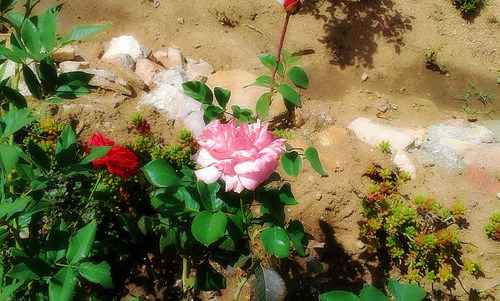

In [17]:
Image.open(str(roses[1]))

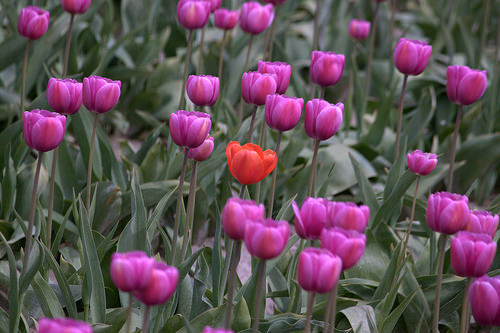

In [18]:
tulips = list(data_dir.glob('tulips/*'))
Image.open(str(tulips[0]))

In [19]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [20]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [21]:
flowers_images_dict['roses'][:5]

[WindowsPath('datasets/flower_photos/roses/15255964454_0a64eb67fa.jpg'),
 WindowsPath('datasets/flower_photos/roses/15274443248_76b9f3eb24.jpg'),
 WindowsPath('datasets/flower_photos/roses/15277801151_5ed88f40f0_n.jpg'),
 WindowsPath('datasets/flower_photos/roses/15312360171_57bde98799_n.jpg'),
 WindowsPath('datasets/flower_photos/roses/15319767030_e6c5602a77_m.jpg')]

In [22]:
str(flowers_images_dict['roses'][0])

'datasets\\flower_photos\\roses\\15255964454_0a64eb67fa.jpg'

In [23]:
img = cv2.imread(str(flowers_images_dict['roses'][0]))

In [24]:
img.shape

(333, 500, 3)

In [25]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [26]:
X = np.array(X)
y = np.array(y)

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [28]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [29]:
X[0].shape

(224, 224, 3)

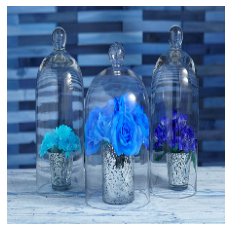

In [34]:
plt.axis('off')
plt.imshow(X[0])

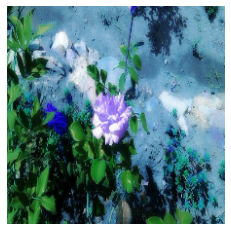

In [35]:
plt.axis('off')
plt.imshow(X[1])

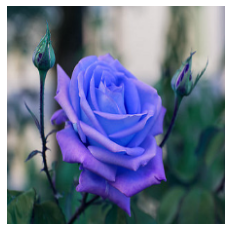

In [36]:
plt.axis('off')
plt.imshow(X[2])

In [33]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=IMAGE_SHAPE+(3,))
])

In [43]:
labels=tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
labels

'C:\\Users\\Admin\\.keras\\datasets\\ImageNetLabels.txt'

In [47]:
image_labels = []
with open("C:\\Users\\Admin\\.keras\\datasets\\ImageNetLabels.txt", "r") as f:
    image_labels = f.read().splitlines()
image_labels[:5]

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

In [37]:
x0_resized = cv2.resize(X[0], IMAGE_SHAPE)
x1_resized = cv2.resize(X[1], IMAGE_SHAPE)
x2_resized = cv2.resize(X[2], IMAGE_SHAPE)

In [38]:
predicted = classifier.predict(np.array([x0_resized, x1_resized, x2_resized]))
predicted = np.argmax(predicted, axis=1)
predicted

array([795, 795, 795], dtype=int64)

In [48]:
image_labels[795]

'shower curtain'

In [49]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [50]:
num_of_flowers = 5

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_flowers)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [53]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

model.fit(X_train_scaled, y_train, epochs=10)

Epoch 1/10
12/12 [==============================] - 8s 563ms/step - loss: 0.3877 - acc: 0.8747
Epoch 2/10
12/12 [==============================] - 7s 547ms/step - loss: 0.2784 - acc: 0.9387
Epoch 3/10
12/12 [==============================] - 7s 585ms/step - loss: 0.2260 - acc: 0.9573
Epoch 4/10
12/12 [==============================] - 7s 539ms/step - loss: 0.1834 - acc: 0.9733
Epoch 5/10
12/12 [==============================] - 7s 569ms/step - loss: 0.1534 - acc: 0.9840
Epoch 6/10
12/12 [==============================] - 7s 554ms/step - loss: 0.1298 - acc: 0.9893
Epoch 7/10
12/12 [==============================] - 7s 548ms/step - loss: 0.1126 - acc: 0.9893
Epoch 8/10
12/12 [==============================] - 7s 581ms/step - loss: 0.0989 - acc: 0.9920
Epoch 9/10
12/12 [==============================] - 6s 532ms/step - loss: 0.0864 - acc: 0.9973
Epoch 10/10
12/12 [==============================] - 7s 579ms/step - loss: 0.0775 - acc: 0.9973


In [54]:
model.evaluate(X_test_scaled,y_test)

4/4 [==============================] - 3s 521ms/step - loss: 0.5542 - acc: 0.7920


[0.5541595220565796, 0.7919999957084656]

In [55]:
IMAGE_SHAPE = (299, 299)

classifier_v3 = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_v3/classification/5", input_shape=IMAGE_SHAPE+(3,))
])

In [56]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(299,299))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [57]:
X = np.array(X)
y = np.array(y)

In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [59]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [61]:
feature_extractor_model = "https://tfhub.dev/google/inaturalist/inception_v3/feature_vector/5"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(299, 299, 3), trainable=False)

In [62]:
num_of_flowers = 5

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_flowers)
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 2048)              21802784  
                                                                 
 dense_1 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [63]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

model.fit(X_train_scaled, y_train, epochs=10)

Epoch 1/10
12/12 [==============================] - 31s 2s/step - loss: 1.4273 - acc: 0.4587
Epoch 2/10
12/12 [==============================] - 26s 2s/step - loss: 0.8068 - acc: 0.8053
Epoch 3/10
12/12 [==============================] - 25s 2s/step - loss: 0.5287 - acc: 0.8987
Epoch 4/10
12/12 [==============================] - 26s 2s/step - loss: 0.3993 - acc: 0.9013
Epoch 5/10
12/12 [==============================] - 26s 2s/step - loss: 0.3189 - acc: 0.9467
Epoch 6/10
12/12 [==============================] - 25s 2s/step - loss: 0.2623 - acc: 0.9547
Epoch 7/10
12/12 [==============================] - 26s 2s/step - loss: 0.2229 - acc: 0.9653
Epoch 8/10
12/12 [==============================] - 25s 2s/step - loss: 0.1945 - acc: 0.9707
Epoch 9/10
12/12 [==============================] - 26s 2s/step - loss: 0.1692 - acc: 0.9813
Epoch 10/10
12/12 [==============================] - 25s 2s/step - loss: 0.1528 - acc: 0.9840


In [64]:
model.evaluate(X_test_scaled,y_test)

4/4 [==============================] - 9s 2s/step - loss: 0.4173 - acc: 0.8560


[0.4172983765602112, 0.8560000061988831]